In [1]:
!nvidia-smi

Mon Aug 24 22:10:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   24C    P8     6W / 180W |      1MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import dependencies

In [2]:
%load_ext autoreload
%autoreload 2

import os
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Example, Field, Dataset
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score

import warnings

import utils
import torch_utils
from optim_utils import LRFinder
from beam_utils import Node, find_best_path

In [3]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


# Load & clean data

There's about 2 millions of examples. If we use all examples, the training will take much time. So, I sampled 200 000 examples to train the model in a reasonable time.

The cleaning step consists of normalizing unicode characters and removing multiple spaces.

In [4]:
%%time
data_fr = utils.read_file('./data/europarl-v7.fr-en.fr')
data_en = utils.read_file('./data/europarl-v7.fr-en.en')

assert len(data_fr) == len(data_en)
print(f'Number of examples: {len(data_fr):,}')

indexes = np.random.choice(range(len(data_fr)), size=200_000, replace=False)

pairs = [*zip(
    utils.clean_lines([data_fr[index] for index in indexes]),
    utils.clean_lines([data_en[index] for index in indexes])
)]
pairs = [*map(lambda x: {'fr': x[0], 'en': x[1]}, pairs)]
print(f'Number of examples after sampling: {len(pairs):,}')
print(f'Example:\n\tFR => {pairs[0]["fr"]}\n\tEN => {pairs[0]["en"]}')

Number of examples: 2,007,723


100%|██████████| 200000/200000 [00:03<00:00, 60282.17it/s]


Number of examples after sampling: 200,000
Example:
	FR => par écrit. - (EN) Les conservateurs saluent l'objectif général visé par l'amélioration des droits des passagers et de l'accès pour les personnes handicapées et par la création de règles équitables pour les utilisateurs de bus internationaux, c'est pourquoi j'ai voté en faveur du rapport.
	EN => in writing. - Conservatives welcome the overall aim of improving passenger rights, access for the disabled and creating a level playing field for international bus users, and for this reason voted in favour of the report.
CPU times: user 9.74 s, sys: 1 s, total: 10.7 s
Wall time: 10.7 s


# Build datasets

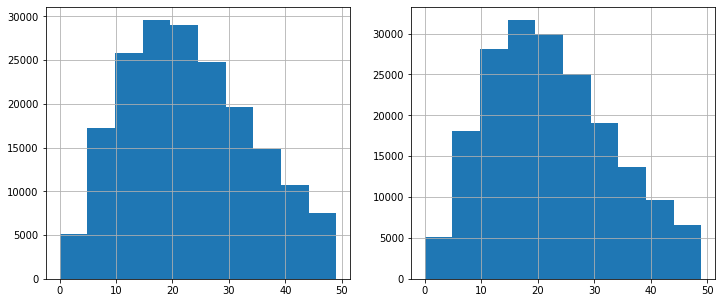

In [5]:
len_fr = [*map(lambda pair: len(pair['fr'].split()), pairs)]
len_en = [*map(lambda pair: len(pair['en'].split()), pairs)]

_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist([*filter(lambda x: x < 50, len_fr)])
axes[0].grid(True)
axes[1].hist([*filter(lambda x: x < 50, len_en)])
axes[1].grid(True)
plt.show()

In [6]:
%%time
MIN_LENGTH, MAX_LENGTH = 10, 25
pairs = [*filter(lambda pair: MIN_LENGTH <= len(pair['fr'].split()) <= MAX_LENGTH and MIN_LENGTH <= len(pair['fr'].split()) <= MAX_LENGTH, pairs)]
print(f'Number of examples after filtering: {len(pairs):,}')

Number of examples after filtering: 89,752
CPU times: user 734 ms, sys: 0 ns, total: 734 ms
Wall time: 733 ms


Now we build *TorchText Fields* that will handle processing text. It consists of:

- Tokenizing using Spacy language models (french and english)
- Add special tokens (init token, pad token, unknown token, end token)
- Numericalizing

In [7]:
%%time
FR = Field(lower=True,
           tokenize='spacy',
           tokenizer_language='fr',
           include_lengths=True)
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='en',
           include_lengths=True)

examples = [Example.fromdict(
    data=pair,
    fields={
        'fr': ('src', FR),
        'en': ('dest', EN)
    }
) for pair in tqdm.tqdm(pairs)]
print(f'Number of examples: {len(examples):,}')

100%|██████████| 89752/89752 [00:37<00:00, 2382.70it/s]

Number of examples: 89,752
CPU times: user 1min, sys: 605 ms, total: 1min 1s
Wall time: 1min 1s


Then we split data into train, validation and test sets with 90% for train set and 5% for validation and test sets each. 5% is about 5000 examples which enough to explains variance in our model.

In [8]:
data = Dataset(examples, fields={'src': FR, 'dest': EN})
train_data, valid_data, test_data = data.split(split_ratio=[0.9, 0.05, 0.05])
print(f'train set size: {len(train_data.examples):,}')
print(f'valid set size: {len(valid_data.examples):,}')
print(f'test set size: {len(test_data.examples):,}')
print(vars(train_data.examples[0]))

train set size: 80,777
valid set size: 4,487
test set size: 4,488
{'src': ['par', 'ailleurs', ',', 'de', 'nombreux', 'experts', 'militaires', 'soulignent', 'le', 'danger', 'd’', 'une', 'intervention', 'en', 'l’', 'absence', 'd’', 'un', 'mandat', 'précis', 'et', 'sans', 'équivoque', '.'], 'dest': ['furthermore', ',', 'many', 'military', 'experts', 'point', 'to', 'the', 'dangers', 'of', 'intervening', 'without', 'a', 'mandate', 'that', 'has', 'been', 'accurately', 'and', 'properly', 'drawn', 'up', '.']}


We also built a vocabulary for each language in other to map each unique token with an index (numeric). We only allow tokens that appears 5 times or more. Tokens that appear less than 5 times are converted into unknown token. 

In [9]:
%%time
MIN_COUNT = 5
FR.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<unk>', '<pad>'])
EN.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
print(f'Length of FR vocabulary: {len(FR.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of FR vocabulary: 12,037
Length of EN vocabulary: 9,417
CPU times: user 1.59 s, sys: 0 ns, total: 1.59 s
Wall time: 1.59 s


# Modeling
<!-- 
<img src="./img/seq2seq-details.svg" alt="sequence-to-sequence details" />

<img src="./img/seq2seq.png" alt="seq2seq" /> -->

## LSTM Encoder model

<!-- <img src="./img/lstm_3.svg" alt="LSTM cell" />

$$
\begin{split}\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o), \\
\tilde{\mathbf{C}}_t &= \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c), \\
\mathbf{C}_t &= \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t
\end{aligned}\end{split}
$$ -->

In [10]:
class EncoderLSTM(nn.Module):
    
    def __init__(
        self,
        embedding_size,
        vocab_size,
        hidden_size,
        n_layers,
        dropout,
        recurrent_dropout
    ):
        super(EncoderLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size,
                            num_layers=n_layers,
                            bidirectional=True,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        
    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)
        
    def fine_tuning_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune
    
    def forward(self, input_sequences, sequence_lengths):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            
        :return
            outputs: Tensor[seq_len, batch_size, 2 * hidden_size]
            hn: Tensor[n_layers * 2, batch_size, hidden_size]
            cn: Tensor[n_layers * 2, batch_size, hidden_size]
        """
        embedded = self.embedding(input_sequences)
        embedded = F.dropout(embedded, p=self.dropout)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, sequence_lengths)
        outputs, (hn, cn) = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        return outputs, hn, cn

In [11]:
%%time
def test_encoder():
    batch_size = 128
    train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True)
    encoder = EncoderLSTM(
        embedding_size=300,
        vocab_size=len(FR.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.35,
        recurrent_dropout=0.25
    )
    for data in train_iterator:
        outputs, hn, cn = encoder(
            input_sequences=data.src[0],
            sequence_lengths=data.src[1]
        )
        seq_len = data.src[0].size(0)
        assert outputs.size() == torch.Size([seq_len, batch_size, 2 * 256]), outputs.size()
        assert hn.size() == torch.Size([4 * 2, batch_size, 256]), hn.size()
        assert cn.size() == torch.Size([4 * 2, batch_size, 256]), cn.size()
        break
    
test_encoder()

CPU times: user 9.88 s, sys: 256 ms, total: 10.1 s
Wall time: 1.89 s


## LSTM Decoder model

In [12]:
class DecoderLSTM(nn.Module):
    
    def __init__(
        self,
        embedding_size,
        vocab_size,
        hidden_size,
        n_layers,
        dropout,
        recurrent_dropout
    ):
        super(DecoderLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)
        
    def fine_tuning_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune
        
    def forward(self, input_word_index, h_state, c_state):
        """
        :params
            input_word_index: Tensor[batch_size,]
            h_state: Tensor[num_layers, batch_size, hidden_size]
            c_state: Tensor[num_layers, batch_size, hidden_size]
            
        :return
            logit: Tensor[batch_size, vocab_size]
            h_state: Tensor[num_layers, batch_size, hidden_size]
            c_state: Tensor[num_layers, batch_size, hidden_size]
        """
        embedded = self.embedding(input_word_index.unsqueeze(0))
        embedded = F.dropout(embedded, p=self.dropout)
        outputs, (h_state, c_state) = self.lstm(embedded, (h_state, c_state))
        logit = self.fc(outputs).squeeze(0)
        return logit, h_state, c_state

In [13]:
%%time
def test_decoder():
    batch_size = 128
    train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True)
    decoder = DecoderLSTM(
        embedding_size=300,
        vocab_size=len(EN.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    for data in train_iterator:
        logit, h_state, c_state = decoder(
            input_word_index=data.dest[0][0],
            h_state=torch.rand(4, batch_size, 256),
            c_state=torch.rand(4, batch_size, 256)
        )
        assert logit.size() == torch.Size([batch_size, len(EN.vocab)]), logit.size()
        assert h_state.size() == torch.Size([4, batch_size, 256]), h_state.size()
        assert c_state.size() == torch.Size([4, batch_size, 256]), c_state.size()
        break
        
test_decoder()

CPU times: user 689 ms, sys: 8.04 ms, total: 697 ms
Wall time: 317 ms


## LSTM Sequence-to-sequence model

In [14]:
class SeqToSeqLSTM(nn.Module):
    
    def __init__(self, encoder, decoder, device):
        assert encoder.n_layers == decoder.n_layers, \
            'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, \
            'Encoder and Decoder must have the same number of reccurrent hidden units'
        
        super(SeqToSeqLSTM, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.init_h0 = nn.Linear(decoder.n_layers * 2, decoder.n_layers) 
        self.init_c0 = nn.Linear(decoder.n_layers * 2, decoder.n_layers)
        self.device = device
        
    def forward(self, src_sequences, src_lengths, dest_sequences, dest_lengths, tf_ratio):
        """
        :params
            src_sequences: Tensor[seq_len, batch_size]
            src_lengths: Tensor[batch_size,]
            dest_sequences: Tensor[seq_len, batch_size]
            dest_lengths: Tensor[batch_size,]
            tf_ratio: float
            
        :return
            logits: Tensor[max(decode_lengths), batch_size, vocab_size]
            sorted_dest_sequences: Tensor[seq_len, batch_size]
            sorted_decode_lengths: Tensor[batch_size,]
            sorted_indices: Tensor[batch_size,]
        """
        # Encoding
        _, h_state, c_state = self.encoder(
            input_sequences=src_sequences,
            sequence_lengths=src_lengths
        )
        # h_state: [n_layers * 2, batch_size, hidden_size]
        # c_state: [n_layers * 2, batch_size, hidden_size]
        
        # Sort the batch (dest) by decreasing lengths
        sorted_dest_lengths, sorted_indices = torch.sort(dest_lengths, dim=0, descending=True)
        sorted_dest_sequences = dest_sequences[:, sorted_indices]
        h_state = h_state[:, sorted_indices, :]
        c_state = c_state[:, sorted_indices, :]
        
        # Init hidden and memory states
        h_state = self.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
        c_state = self.init_c0(c_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
        h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
        c_state = c_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
        
        # We won't decode at the <eos> position, since we've finished generating as soon as we generate <eos>
        # So, decoding lengths are actual lengths - 1
        sorted_decode_lengths = (sorted_dest_lengths - 1).tolist()
        
        # Decoding
        batch_size, last = dest_sequences.size(1), None
        logits = torch.zeros(max(sorted_decode_lengths), batch_size, self.decoder.vocab_size).to(self.device)
        for t in range(max(sorted_decode_lengths)):
            batch_size_t = sum([l > t for l in sorted_decode_lengths])
            if last is not None:
                if random.random() < tf_ratio:
                    in_ = last[:batch_size_t]
                else:
                    in_ = sorted_dest_sequences[t, :batch_size_t]
            else:
                in_ = sorted_dest_sequences[t, :batch_size_t]
            # in_ [batch_size,]
            logit, h_state, c_state = self.decoder(
                in_, 
                h_state[:, :batch_size_t, :].contiguous(),
                c_state[:, :batch_size_t, :].contiguous()
            )
            # logit: [batch_size, vocab_size]
            # h_state: [num_layers, batch_size, hidden_size]
            # c_state: [num_layers, batch_size, hidden_size]
            logits[t, :batch_size_t, :] = logit
            last = torch.argmax(F.softmax(logit, dim=1), dim=1) # [batch_size,]
        
        return logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices

In [15]:
%%time
def test_seq2seq():
    batch_size = 128
    train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True)
    encoder = EncoderLSTM(
        embedding_size=300,
        vocab_size=len(FR.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    decoder = DecoderLSTM(
        embedding_size=300,
        vocab_size=len(EN.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    model = SeqToSeqLSTM(encoder, decoder, device='cpu')
    for data in train_iterator:
        logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices = \
            model(
                src_sequences=data.src[0], 
                src_lengths=data.src[1],
                dest_sequences=data.dest[0],
                dest_lengths=data.dest[1],
                tf_ratio=0.
            )
        assert logits.size() == torch.Size([
            max(sorted_decode_lengths),
            batch_size,
            len(EN.vocab)
        ]), logits.size()
        assert sorted_dest_sequences.size() == torch.Size([
            data.dest[0].shape[0],
            batch_size
        ]), sorted_dest_sequences.size()
        assert len(sorted_decode_lengths) == batch_size, len(sorted_decode_lengths)
        assert sorted_indices.size() == torch.Size([
            batch_size,
        ]), sorted_indices.size()
        break
        
test_seq2seq()

CPU times: user 15.6 s, sys: 407 ms, total: 16 s
Wall time: 2.8 s


## Training routines

In [16]:
def train_step(model, optimizer, criterion, loader, epoch, grad_clip, tf_ratio, device):
    loss_tracker, acc_tracker = utils.AverageMeter(), utils.AverageMeter()
    model.train()
    pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
    for i, data in pbar:
        # Forward prop.
        logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices = \
            model(*data.src, *data.dest, tf_ratio=tf_ratio)
        # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
        sorted_dest_sequences = sorted_dest_sequences[1:, :]
        # Remove paddings
        logits = nn.utils.rnn.pack_padded_sequence(
            logits,
            sorted_decode_lengths
        ).data
        sorted_dest_sequences = nn.utils.rnn.pack_padded_sequence(
            sorted_dest_sequences,
            sorted_decode_lengths
        ).data
        # Calculate loss
        loss = criterion(logits, sorted_dest_sequences)
        # Back prop.
        optimizer.zero_grad()
        loss.backward()
        # Clip gradients
        if grad_clip is not None:
            torch_utils.clip_gradient(optimizer, grad_clip)
        # Update weights
        optimizer.step()
        # Track metrics
        loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
        acc_tracker.update(
            torch_utils.accuracy(logits, sorted_dest_sequences, 5),
            sum(sorted_decode_lengths)
        )
        # Update progressbar description
        pbar.set_description(f'Epoch: {epoch + 1:03d} - loss: {loss_tracker.average:.3f} - acc: {acc_tracker.average:.3f}%')
    return loss_tracker.average, acc_tracker.average

In [17]:
def validate(model, criterion, loader, field, epoch, device):
    references, hypotheses = [], []
    loss_tracker, acc_tracker = utils.AverageMeter(), utils.AverageMeter()
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, data in pbar: 
            # Forward prop.
            logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices = \
                model(*data.src, *data.dest, tf_ratio=0.)
            # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
            sorted_dest_sequences = sorted_dest_sequences[1:, :]
            # Remove paddings
            logits_copy = logits.clone()
            logits = nn.utils.rnn.pack_padded_sequence(
                logits,
                sorted_decode_lengths
            ).data
            sorted_dest_sequences = nn.utils.rnn.pack_padded_sequence(
                sorted_dest_sequences,
                sorted_decode_lengths
            ).data
            # Calculate loss
            loss = criterion(logits, sorted_dest_sequences)
            # Track metrics
            loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
            acc_tracker.update(
                torch_utils.accuracy(logits, sorted_dest_sequences, 5),
                sum(sorted_decode_lengths)
            )
            # Update references
            target_sequences = data.dest[0].t()[sorted_indices]
            for j in range(target_sequences.size(0)):
                target_sequence = target_sequences[j].tolist()
                reference = [
                    field.vocab.itos[indice] 
                    for indice in target_sequence 
                    if indice not in (
                        field.vocab.stoi[field.init_token],
                        field.vocab.stoi[field.pad_token]
                    )
                ]
                references.append([reference])
            # Update hypotheses
            _, preds = torch.max(logits_copy, dim=2)
            preds = preds.t().tolist()
            for j, p in enumerate(preds):
                hypotheses.append([
                    field.vocab.itos[indice] 
                    for indice in preds[j][:sorted_decode_lengths[j]] # Remove padding
                    if indice not in (
                        field.vocab.stoi[field.init_token],
                        field.vocab.stoi[field.pad_token]
                    )
                ])
            assert len(references) == len(hypotheses)
            # Update progressbar description
            pbar.set_description(f'Epoch: {epoch + 1:03d} - val_loss: {loss_tracker.average:.3f} - val_acc: {acc_tracker.average:.3f}%')
        # Calculate BLEU-4 score
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
        # Display some examples
        for i in np.random.choice(len(loader), size=3, replace=False):
            src, dest = ' '.join(references[i][0]), ' '.join(hypotheses[i])
            display(HTML(f'<span style="color:blue"><b>Ground truth translation:</b> {src}</span>'))
            display(HTML(f'<span style="color:red"><b>Predicted translation:</b> {dest}</span>'))
            print('='*100)
    return loss_tracker.average, acc_tracker.average, bleu4

In [18]:
def train(model, optimizer, criterion, train_loader, valid_loader, field, n_epochs, grad_clip, tf_ratio, last_improv, model_name, device):
    history, best_bleu = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': [],
        'bleu4': []
    }, 0.
    for epoch in range(n_epochs):
         # Stop training if no improvment since last 4 epochs
        if last_improv == 4:
            print('Training Finished - The model has stopped improving since last 4 epochs')
            break
        # Decay LR if no improvment
        if last_improv > 0:
            torch_utils.adjust_lr(optimizer=optimizer,
                                  shrink_factor=0.9,
                                  verbose=True)
        # Train step
        loss, acc = train_step(model=model,
                               optimizer=optimizer,
                               criterion=criterion,
                               loader=train_loader,
                               epoch=epoch,
                               grad_clip=grad_clip, 
                               tf_ratio=tf_ratio,
                               device=device)
        # Validation step
        val_loss, val_acc, bleu4 = validate(model=model,
                                            criterion=criterion,
                                            loader=valid_loader,
                                            field=field,
                                            epoch=epoch,
                                            device=device)
        # Update history dict
        history['acc'].append(acc)
        history['loss'].append(loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        history['bleu4'].append(bleu4)
        # Print BLEU score
        text = f'BLEU-4: {bleu4*100:.3f}%'
        if bleu4 > best_bleu:
            best_bleu, last_improv = bleu4, 0
        else:
            last_improv += 1
            text += f' - Last improvement since {last_improv} epoch(s)'
        print(text)
        # Decrease teacher forcing rate
        tf_ratio = torch_utils.adjust_tf(tf_ratio,
                                         shrink_factor=0.8,
                                         verbose=False)
        # Save checkpoint
        torch_utils.save_checkpoint(model=model,
                                    optimizer=optimizer,
                                    data_name=model_name,
                                    epoch=epoch,
                                    last_improv=last_improv,
                                    bleu4=bleu4,
                                    is_best=bleu4 >= best_bleu)
    return history

## Initialize models

In [19]:
%%time
# Load word vectors
spacy_fr = spacy.load('fr_core_news_lg') # CBOW trained word vectors
spacy_en = spacy.load('en_core_web_lg') # GloVe trained word vectors

CPU times: user 9.04 s, sys: 1.43 s, total: 10.5 s
Wall time: 10.5 s


In [20]:
# Load embeddings
fr_embeddings = torch_utils.load_embeddings(nlp=spacy_fr, field=FR)
en_embeddings = torch_utils.load_embeddings(nlp=spacy_en, field=EN)

100%|██████████| 9442/9442 [01:38<00:00, 95.68it/s] 


In [21]:
MODEL_NAME = 'seq2seq-lstm'
N_LAYERS = 4
HIDDEN_SIZE = 512
EMBEDDING_SIZE = 300
ENC_DROPOUT = 0.3
ENC_RECURRENT_DROPOUT = 0.25
DEC_DROPOUT = 0.15
DEC_RECURRENT_DROPOUT = 0.2
N_EPOCHS = 15
BATCH_SIZE = 64
INIT_LR = 1e-5
GRAD_CLIP = 1.0
TF_RATIO = 1.0
END_LR = 10
N_ITERS = 100

In [22]:
encoder = EncoderLSTM(
    embedding_size=EMBEDDING_SIZE,
    vocab_size=len(FR.vocab),
    hidden_size=HIDDEN_SIZE,
    n_layers=N_LAYERS,
    dropout=ENC_DROPOUT,
    recurrent_dropout=ENC_RECURRENT_DROPOUT
)
encoder.load_pretrained_embeddings(fr_embeddings)
encoder.fine_tuning_embeddings(fine_tune=True)
decoder = DecoderLSTM(
    embedding_size=EMBEDDING_SIZE,
    vocab_size=len(EN.vocab),
    hidden_size=HIDDEN_SIZE,
    n_layers=N_LAYERS,
    dropout=DEC_DROPOUT,
    recurrent_dropout=DEC_RECURRENT_DROPOUT
)
decoder.load_pretrained_embeddings(en_embeddings)
decoder.fine_tuning_embeddings(fine_tune=True)
seq2seq = SeqToSeqLSTM(encoder=encoder, decoder=decoder, device=DEVICE)
seq2seq.apply(torch_utils.xavier_init_weights)
seq2seq.to(DEVICE)
optimizer = optim.RMSprop(params=seq2seq.parameters(), lr=INIT_LR)
criterion = nn.CrossEntropyLoss()
print(f'Number of parameters of the model: {torch_utils.count_parameters(seq2seq):,}')

Number of parameters of the model: 41,471,097


### Training

In [23]:
train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=BATCH_SIZE,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True,
                              device=DEVICE)

In [24]:
lr_finder = LRFinder(model=seq2seq,
                     optimizer=optimizer,
                     criterion=criterion,
                     grad_clip=GRAD_CLIP)

lr_finder.range_test(data_loader=train_iterator,
                     end_lr=END_LR, n_iters=N_ITERS)

 78%|███████▊  | 78/100 [00:18<00:05,  4.24it/s]

Stopping early, the loss has diverged!


Learning rate search finished. See the graph with {finder_name}.plot()


Suggested LR (steepest gradient): 1.63E-04


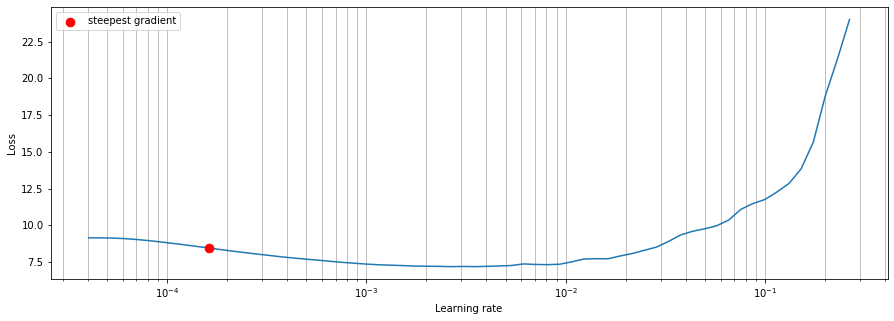

In [25]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax, lr = lr_finder.plot(ax=ax)
plt.show()

In [26]:
optimizer = optim.RMSprop(params=seq2seq.parameters(), lr=lr)

In [27]:
history = train(model=seq2seq,
                optimizer=optimizer,
                criterion=criterion,
                train_loader=train_iterator,
                valid_loader=valid_iterator,
                field=EN,
                n_epochs=N_EPOCHS,
                grad_clip=GRAD_CLIP,
                tf_ratio=TF_RATIO,
                last_improv=0,
                model_name=MODEL_NAME,
                device=DEVICE)

Epoch: 001 - val_loss: 5.419 - val_acc: 4.968%: 100%|██████████| 71/71 [00:06<00:00, 10.67it/s]


BLEU-4: 1.151%


Epoch: 002 - val_loss: 5.028 - val_acc: 5.627%: 100%|██████████| 71/71 [00:06<00:00, 10.63it/s]


BLEU-4: 2.462%


Epoch: 003 - val_loss: 4.514 - val_acc: 6.537%: 100%|██████████| 71/71 [00:06<00:00, 10.70it/s]


BLEU-4: 4.547%


Epoch: 004 - val_loss: 4.179 - val_acc: 7.162%: 100%|██████████| 71/71 [00:06<00:00, 10.64it/s]


BLEU-4: 6.413%


Epoch: 005 - val_loss: 3.963 - val_acc: 7.574%: 100%|██████████| 71/71 [00:06<00:00, 10.70it/s]


BLEU-4: 7.701%


Epoch: 006 - val_loss: 3.775 - val_acc: 7.947%: 100%|██████████| 71/71 [00:07<00:00,  9.49it/s]


BLEU-4: 8.933%


Epoch: 007 - val_loss: 3.598 - val_acc: 8.325%: 100%|██████████| 71/71 [00:06<00:00, 10.43it/s]


BLEU-4: 10.198%


Epoch: 008 - val_loss: 3.489 - val_acc: 8.542%: 100%|██████████| 71/71 [00:06<00:00, 10.44it/s]


BLEU-4: 10.944%


Epoch: 009 - val_loss: 3.372 - val_acc: 8.768%: 100%|██████████| 71/71 [00:06<00:00, 10.55it/s]


BLEU-4: 11.875%


Epoch: 010 - val_loss: 3.289 - val_acc: 8.943%: 100%|██████████| 71/71 [00:06<00:00, 10.51it/s]


BLEU-4: 12.759%


Epoch: 011 - val_loss: 3.218 - val_acc: 9.086%: 100%|██████████| 71/71 [00:06<00:00, 10.38it/s]


BLEU-4: 13.509%


Epoch: 012 - val_loss: 3.149 - val_acc: 9.241%: 100%|██████████| 71/71 [00:06<00:00, 10.62it/s]


BLEU-4: 13.995%


Epoch: 013 - val_loss: 3.099 - val_acc: 9.343%: 100%|██████████| 71/71 [00:06<00:00, 10.71it/s]


BLEU-4: 14.558%


Epoch: 014 - val_loss: 3.063 - val_acc: 9.418%: 100%|██████████| 71/71 [00:06<00:00, 10.38it/s]


BLEU-4: 14.732%


Epoch: 015 - val_loss: 3.043 - val_acc: 9.466%: 100%|██████████| 71/71 [00:06<00:00, 10.54it/s]


BLEU-4: 15.063%


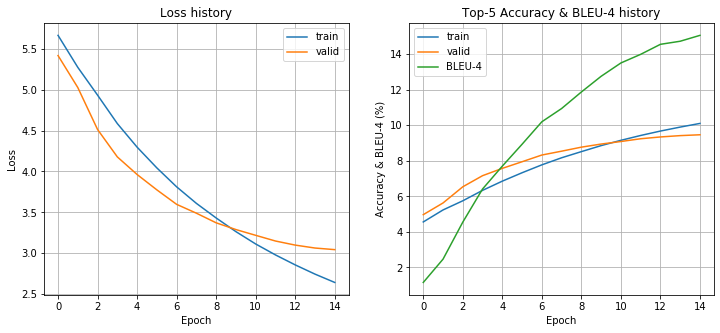

In [28]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()
axes[1].plot(history['acc'], label='train')
axes[1].plot(history['val_acc'], label='valid')
axes[1].plot(np.array(history['bleu4']) * 100., label='BLEU-4')
axes[1].set_title('Top-5 Accuracy & BLEU-4 history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy & BLEU-4 (%)')
axes[1].grid(True)
axes[1].legend()
plt.show()

### Evaluation

In [29]:
seq2seq.load_state_dict(torch.load(f'./checkpoint/BEST_{MODEL_NAME}.pt').get('model'))

<All keys matched successfully>

In [30]:
def evaluate(model, loader, beam_size, src_field, dest_field, max_len, device):
    """
    Evaluation with Beam search
    """
    references, hypotheses, sources = [], [], []
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, data in pbar:
            (src_sequences, src_lengths) = data.src[0], data.src[1]
            (dest_sequences, dest_lengths) = data.dest[0], data.dest[1]
            
            batch_size = src_sequences.shape[1]
            for j in range(batch_size): # We evaluate sentence by sentence
                src_sequence = src_sequences[:, j].unsqueeze(1) # [seq_len, 1]
                dest_sequence = dest_sequences[:, j].unsqueeze(1) # [seq_len, 1]
                src_length, dest_length = src_lengths[j, None], dest_lengths[j, None] # [1,]
                
                # Encoding
                _, h_state, c_state = model.encoder(input_sequences=src_sequence,
                                                    sequence_lengths=src_length)
                
                # Init hidden and memory states
                h_state = model.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
                c_state = model.init_c0(c_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
                h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
                c_state = c_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
                
                # Decoding
                tree = [[Node(
                    token=torch.LongTensor([
                        dest_field.vocab.stoi[dest_field.init_token]
                    ]).to(device),
                    states=(h_state, c_state)
                )]]
                
                for _ in range(max_len):
                    next_nodes = []
                    for node in tree[-1]:
                        # Skip eos token
                        if node.eos:
                            continue
                        # Decode
                        logit, h_state, c_state = model.decoder(
                            input_word_index=node.token, 
                            h_state=node.states[0].contiguous(),
                            c_state=node.states[1].contiguous()
                        )
                        # logit: [1, vocab_size]
                        # h_state: [n_layers, 1, hidden_size]
                        # c_state: [n_layers, 1, hidden_size]

                        # Get scores
                        logp = F.log_softmax(logit, dim=1).squeeze(dim=0) # [vocab_size]

                        # Get top k tokens & logps
                        topk_logps, topk_tokens = torch.topk(logp, beam_size)

                        for k in range(beam_size):
                            next_nodes.append(Node(
                                token=topk_tokens[k, None],
                                states=(h_state, c_state),
                                logp=topk_logps[k, None].cpu().item(),
                                parent=node,
                                eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]
                            ))
                    
                    if len(next_nodes) == 0:
                        break
                    
                    # Sort next_nodes to get the best
                    next_nodes = sorted(next_nodes,
                                        key=lambda node: node.logps,
                                        reverse=True)
                    # Update the tree
                    tree.append(next_nodes[:beam_size])
                
                # Find the best path of the tree
                best_path = find_best_path(tree)
                
                # Get the translation
                pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
                pred_translated = [*filter(lambda word: word not in [
                    dest_field.init_token, dest_field.eos_token
                ], pred_translated[::-1])]
                
                # Update hypotheses
                hypotheses.append(pred_translated)
                
                # Update references
                references.append([[
                    dest_field.vocab.itos[indice] 
                    for indice in dest_sequence 
                    if indice not in (
                        dest_field.vocab.stoi[dest_field.init_token],
                        dest_field.vocab.stoi[dest_field.eos_token],
                        dest_field.vocab.stoi[dest_field.pad_token]
                    )
                ]])
                
                # Update sources
                sources.append([
                    src_field.vocab.itos[indice] 
                    for indice in src_sequence 
                    if indice not in (
                        src_field.vocab.stoi[src_field.init_token],
                        src_field.vocab.stoi[src_field.eos_token],
                        src_field.vocab.stoi[src_field.pad_token]
                    )
                ])
    
        # Calculate BLEU-4 score
        assert len(hypotheses) == len(references) == len(sources)
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    
    return hypotheses, references, sources, bleu4

In [31]:
_, _, _, bleu4 = evaluate(seq2seq.to(DEVICE),
                          loader=test_iterator,
                          beam_size=1,
                          src_field=FR,
                          dest_field=EN,
                          max_len=MAX_LENGTH,
                          device=DEVICE)
print(f'BLEU-4: {bleu4*100:.3f}% with beam_size=1')

100%|██████████| 71/71 [02:33<00:00,  2.17s/it]


BLEU-4: 12.805% with beam_size=1


In [32]:
_, _, _, bleu4 = evaluate(seq2seq.to(DEVICE),
                          loader=test_iterator,
                          beam_size=5,
                          src_field=FR,
                          dest_field=EN,
                          max_len=MAX_LENGTH,
                          device=DEVICE)
print(f'BLEU-4: {bleu4*100:.3f}% with beam_size=5')

100%|██████████| 71/71 [12:36<00:00, 10.65s/it]


BLEU-4: 13.688% with beam_size=5


# Inference

In [60]:
def translate(sentences, model, beam_size, src_field, dest_field, max_len, device):
    """
    Translate sentences
    """
    if isinstance(sentences, list):
        sentences = [*map(src_field.preprocess, sentences)]
        targets = None
    if isinstance(sentences, Dataset):
        targets = [*map(lambda example: ' '.join(example.dest), sentences.examples)]
        sentences = [*map(lambda example: example.src, sentences.examples)]
    data = [*map(lambda word_list: src_field.process([word_list]), sentences)]
    
    translated_sentences, pred_logps = [], []
    
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(data), total=len(data))
        for i, (src_sequence, src_length) in pbar:
            src_sequence, src_length = src_sequence.to(device), src_length.to(device)
                
            # Encoding
            _, h_state, c_state = model.encoder(input_sequences=src_sequence,
                                                sequence_lengths=src_length)
                
            # Init hidden and memory states
            h_state = model.init_h0(h_state.permute(1, 2, 0)) # [1, hidden_size, n_layers]
            c_state = model.init_c0(c_state.permute(1, 2, 0)) # [1, hidden_size, n_layers]
            h_state = h_state.permute(2, 0, 1) # [n_layers, 1, hidden_size]
            c_state = c_state.permute(2, 0, 1) # [n_layers, 1, hidden_size]
                
            # Decoding
            tree = [[Node(
                token=torch.LongTensor([
                    dest_field.vocab.stoi[dest_field.init_token]
                ]).to(device),
                states=(h_state, c_state)
            )]]
               
            # Generate tokens
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    # Skip eos token
                    if node.eos:
                        continue
                    # Decode
                    logit, h_state, c_state = model.decoder(
                        input_word_index=node.token, 
                        h_state=node.states[0].contiguous(),
                        c_state=node.states[1].contiguous()
                    )
                    # logit: [1, vocab_size]
                    # h_state: [n_layers, 1, hidden_size]
                    # c_state: [n_layers, 1, hidden_size]

                    # Get scores
                    logp = F.log_softmax(logit, dim=1).squeeze(dim=0) # [vocab_size]

                    # Get top k tokens & logps
                    topk_logps, topk_tokens = torch.topk(logp, beam_size)

                    for k in range(beam_size):
                        next_nodes.append(Node(
                            token=topk_tokens[k, None],
                            states=(h_state, c_state),
                            logp=topk_logps[k, None].cpu().item(),
                            parent=node,
                            eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]
                        ))
                
                if len(next_nodes) == 0:
                    break

                # Sort next_nodes to get the best
                next_nodes = sorted(next_nodes,
                                    key=lambda node: node.logps,
                                    reverse=True)
                # Update the tree
                tree.append(next_nodes[:beam_size])
                
            # Find the best path of the tree
            best_path = find_best_path(tree)

            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [
                dest_field.init_token, dest_field.eos_token
            ], pred_translated[::-1])]
            translated_sentences.append(' '.join(pred_translated))
            
            # Get probabilities
            pred_logps.append(sum([*map(lambda node: node.logps, best_path)]))
            
            
        sentences = [*map(lambda sentence: ' '.join(sentence), sentences)]
    return sentences, translated_sentences, targets, pred_logps

In [61]:
sentences, translated_sentences, dest_sentences, pred_logps = translate(sentences=test_data,
                                                                        model=seq2seq,
                                                                        beam_size=5,
                                                                        src_field=FR,
                                                                        dest_field=EN,
                                                                        max_len=MAX_LENGTH,
                                                                        device=DEVICE)

indexes = np.random.choice(len(test_data.examples), size=20, replace=False)
print(indexes)
print()
for i in indexes:
    html = f'<p><span style="color:blue"><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:red"><b>Predicted translation:</b> {translated_sentences[i]}</span></p>'
    display(HTML(html))
    print('='*100)

100%|██████████| 4488/4488 [12:14<00:00,  6.11it/s]

[3421 3631 2434 4267 2376  736 3931 2973 2018 2233 1180 2489 3555 1856
 3330 1678 1260 2811 4168 3154]



# Error Analysis

In [57]:
def get_dest_logp(model, data, src_field, dest_field, device):
    dest_logps = []
        
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(data), total=len(data))
        for i, data in pbar:
            src_sequence, src_length = src_field.process([data.src])
            dest_sequence, dest_length = dest_field.process([data.dest])
            src_sequence, src_length = src_sequence.to(device), src_length.to(device)
            dest_sequence, dest_length = dest_sequence.to(device), dest_length.to(device)
                
            # Encoding
            _, h_state, c_state = model.encoder(input_sequences=src_sequence,
                                                sequence_lengths=src_length)
                
            # Init hidden and memory states
            h_state = model.init_h0(h_state.permute(1, 2, 0)) # [1, hidden_size, n_layers]
            c_state = model.init_c0(c_state.permute(1, 2, 0)) # [1, hidden_size, n_layers]
            h_state = h_state.permute(2, 0, 1) # [n_layers, 1, hidden_size]
            c_state = c_state.permute(2, 0, 1) # [n_layers, 1, hidden_size]
            
            logps = []
            
            # Decoding
            input_word_index = torch.LongTensor([
                dest_field.vocab.stoi[dest_field.init_token]
            ]).to(device)
            
            # Generate tokens
            for idx in range(dest_sequence.shape[0]):
                # Decode
                logit, h_state, c_state = model.decoder(
                    input_word_index=input_word_index, 
                    h_state=h_state.contiguous(),
                    c_state=c_state.contiguous()
                )
                # logit: [1, vocab_size]
                # h_state: [n_layers, 1, hidden_size]
                # c_state: [n_layers, 1, hidden_size]
                
                # Get scores
                logp = F.log_softmax(logit, dim=1).squeeze(dim=0) # [vocab_size]
                
                # Get logp of ground truth ouput
                input_word_index = dest_sequence[idx]
                logps.append(logp[input_word_index].cpu().item())
                
            dest_logps.append(sum(logps))
    
    return dest_logps

dest_logps = get_dest_logp(model=seq2seq,
                           data=test_data,
                           src_field=FR,
                           dest_field=EN,
                           device=DEVICE)

100%|██████████| 4488/4488 [01:49<00:00, 40.80it/s]


In [62]:
assert len(pred_logps) == len(dest_logps) == len(test_data), f'{len(pred_logps)}, {len(dest_logps)}, {len(test_data)}'

In [93]:
beam_search_faults = np.array(dest_logps) > np.array(pred_logps)

beam_search_fault_rate = beam_search_faults.sum() / beam_search_faults.size
print(f'Beam search fault rate: {beam_search_fault_rate * 100:.3f}%')
print(f'Model fault rate: {(1 - beam_search_fault_rate) * 100:.3f}%')

Beam search fault rate: 94.786%
Model fault rate: 5.214%


In [94]:
beam_search_fault_indexes = np.where(beam_search_faults == True)[0]
model_fault_indexes = np.where(beam_search_faults == False)[0]

In [95]:
for i in np.random.choice(beam_search_fault_indexes, size=5, replace=False):
    html = f'<p><span style="color:blue"><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:red"><b>Predicted translation (Beam search fault):</b> {translated_sentences[i]}</span><br />'
    display(HTML(html))
    print('='*100)

In [97]:
for i in np.random.choice(model_fault_indexes, size=5, replace=False):
    html = f'<p><span><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:blue"><b>Predicted translation (Model fault):</b> {translated_sentences[i]}</span><br />'
    display(HTML(html))
    print('='*100)

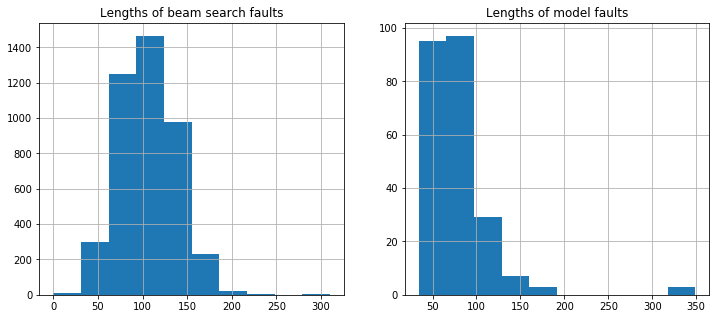

In [106]:
lengths = np.array([*map(len, dest_sentences)])

_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(lengths[beam_search_fault_indexes])
axes[0].set_title('Lengths of beam search faults')
axes[0].grid(True)
axes[1].hist(lengths[model_fault_indexes])
axes[1].set_title('Lengths of model faults')
axes[1].grid(True)
plt.show()